In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
df = yf.Ticker('^GSPC')

In [3]:
df = df.history(period = 'max')

In [4]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-06 00:00:00-05:00,4364.270020,4372.209961,4347.529785,4365.979980,3656340000,0.0,0.0
2023-11-07 00:00:00-05:00,4366.209961,4386.259766,4355.410156,4378.379883,3791230000,0.0,0.0
2023-11-08 00:00:00-05:00,4384.370117,4391.200195,4359.759766,4382.779785,3729510000,0.0,0.0


In [5]:
df.index = df.index.strftime('%Y-%m-%d')

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
df = df.loc['1990-01-01':].copy()

In [8]:
df = df.drop(columns= ['Dividends', 'Stock Splits'])

In [9]:
df['Target'] = df['Close'].shift(-1)

In [10]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Target']].round(2)

<Axes: xlabel='Date'>

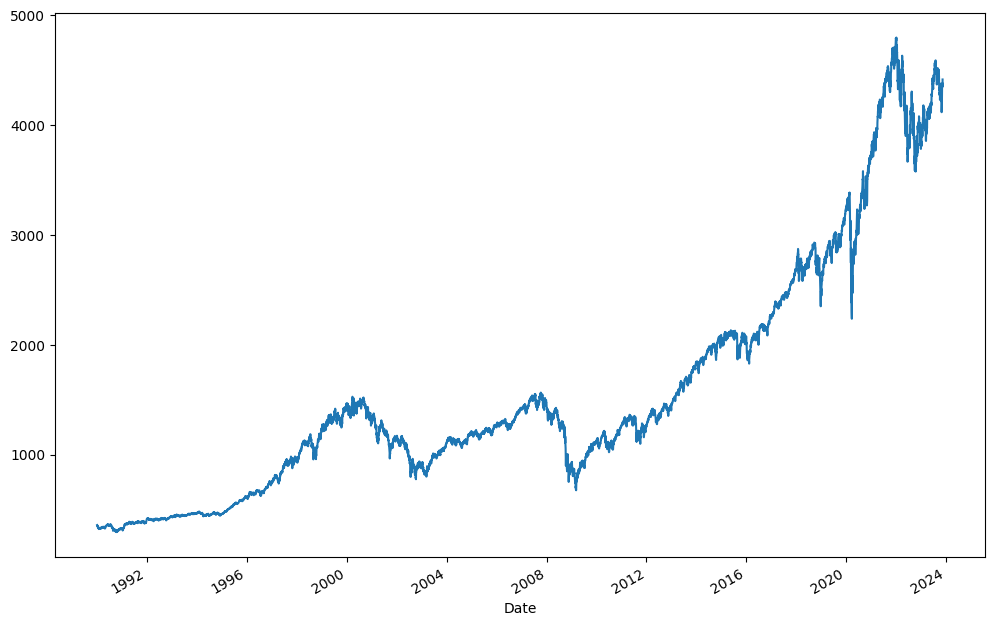

In [11]:
plt.figure(figsize = (12,8))
df['Close'].plot(use_index = True)

In [12]:
df['Target'] = df['Close'] < df['Target']

In [13]:
df['Target']= df['Target'].astype('int')

In [15]:
df

,Open,High,Low,Close,Volume,Target
Date,,,,,,
1990-01-02,353.40,359.69,351.98,359.69,162070000,0
1990-01-03,359.69,360.59,357.89,358.76,192330000,0
1990-01-04,358.76,358.76,352.89,355.67,177000000,0
1990-01-05,355.67,355.67,351.35,352.20,158530000,1
1990-01-08,352.20,354.24,350.54,353.79,140110000,0
...,...,...,...,...,...,...
2023-11-06,4364.27,4372.21,4347.53,4365.98,3656340000,1
2023-11-07,4366.21,4386.26,4355.41,4378.38,3791230000,1
2023-11-08,4384.37,4391.20,4359.76,4382.78,3729510000,0


In [16]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

initial_model = XGBClassifier(n_estimators=100)
train = df.iloc[:-100]
test = df.iloc[-100:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume']

initial_model.fit(train[predictors], train['Target'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
preds = initial_model.predict(test[predictors])

In [18]:
from sklearn.metrics import precision_score

In [19]:
precision_score(test['Target'], preds)

0.5070422535211268

In [20]:
preds = pd.Series(preds, index=test.index, name='Predictions')

In [21]:
combined = pd.concat([test['Target'], preds], axis=1)

In [22]:
combined

,Target,Predictions
Date,,
2023-06-22,0,1
2023-06-23,0,0
2023-06-26,1,0
2023-06-27,0,1
2023-06-28,1,1
...,...,...
2023-11-06,1,1
2023-11-07,1,1
2023-11-08,0,1


In [23]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined
    

In [24]:
len(df)

8532

In [25]:
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []
    
    for i in range(start, len(df), step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)
            

Initial model's

In [26]:
initial_xgb = XGBClassifier(n_estimators=100)
initial_forest = RandomForestClassifier(n_estimators=100)

In [27]:
#Old predictors 

predictions_forest = backtest(df, initial_forest, predictors)
predictions_xgb = backtest(df, initial_xgb, predictors)

KeyboardInterrupt: 

In [ ]:
precision_score(predictions_forest['Target'], predictions_forest['Predictions'])

In [ ]:
precision_score(predictions_xgb['Target'], predictions_xgb['Predictions'])

Initial feature engineering

In [28]:
#ratio_column is ratio of close price/mean price per horizon - based on mean reversion strategy
#trend column is sum of growth days in the horizon 

horizons = [2, 5, 60, 200]
new_predictors = []


for horizon in horizons:
    rolling_avg = df.rolling(horizon).mean()
    erolling_avg = df.ewm(span = horizon, adjust = False).mean()
    
    ratio_column = f'close_ratio{horizon}'
    df[ratio_column] = df['Close']/rolling_avg['Close']
    
    trend_column = f'Trend_{horizon}'
    df[trend_column] = df.shift(1).rolling(horizon).sum()['Target']

    ema_column = f'EMA_{horizon}'
    df[ema_column] = df['Close']/erolling_avg['Close']
    
    new_predictors += [ratio_column, trend_column, ema_column]

In [29]:
df

,Open,High,Low,Close,Volume,Target,close_ratio2,Trend_2,EMA_2,close_ratio5,Trend_5,EMA_5,close_ratio60,Trend_60,EMA_60,close_ratio200,Trend_200,EMA_200
Date,,,,,,,,,,,,,,,,,,
1990-01-02,353.40,359.69,351.98,359.69,162070000,0,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000
1990-01-03,359.69,360.59,357.89,358.76,192330000,0,0.998706,NaN,0.999137,NaN,NaN,0.998275,NaN,NaN,0.997499,NaN,NaN,0.997440
1990-01-04,358.76,358.76,352.89,355.67,177000000,0,0.995675,0.0,0.996824,NaN,NaN,0.993094,NaN,NaN,0.989267,NaN,NaN,0.988959
1990-01-05,355.67,355.67,351.35,352.20,158530000,1,0.995098,0.0,0.995662,NaN,NaN,0.988875,NaN,NaN,0.980271,NaN,NaN,0.979512
1990-01-08,352.20,354.24,350.54,353.79,140110000,0,1.002252,1.0,1.000052,0.993731,NaN,0.995550,NaN,NaN,0.985191,NaN,NaN,0.984091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,4364.27,4372.21,4347.53,4365.98,3656340000,1,1.000876,2.0,1.002461,1.016585,5.0,1.013562,1.002063,30.0,1.008761,1.027392,104.0,1.023032
2023-11-07,4366.21,4386.26,4355.41,4378.38,3791230000,1,1.001418,2.0,1.001763,1.010784,5.0,1.010900,1.005337,30.0,1.011241,1.029875,104.0,1.025673
2023-11-08,4384.37,4391.20,4359.76,4382.78,3729510000,0,1.000502,2.0,1.000922,1.005074,5.0,1.007913,1.006560,31.0,1.011850,1.030467,105.0,1.026431


In [30]:
df = df.dropna()

In [31]:
#New predictors 

#Base on initial model new_predictors are looking better

predictions_forest = backtest(df, initial_forest, new_predictors)
predictions_xgb = backtest(df, initial_xgb, new_predictors)

KeyboardInterrupt: 

In [ ]:
precision_score(predictions_forest['Target'], predictions_forest['Predictions'])

In [ ]:
precision_score(predictions_xgb['Target'], predictions_xgb['Predictions'])

EDA

Text(0.5, 0.92, 'Price and volume distribution')

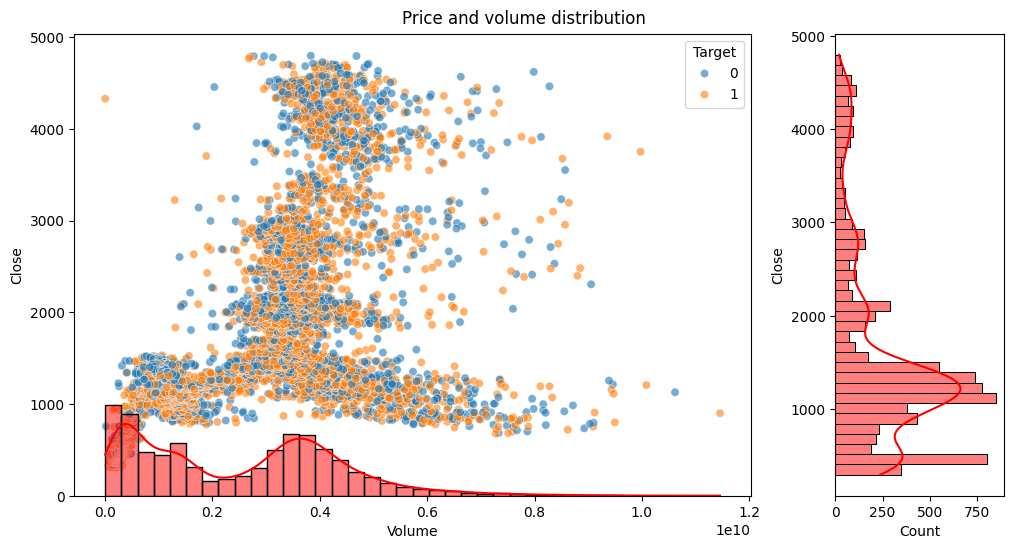

In [32]:
fig, ax = plt.subplots(1,2 ,figsize = (12,6), width_ratios=[4,1])


sns.histplot(y = df['Close'], kde=True, color='r')
sns.scatterplot(y = df['Close'], x = df['Volume'], alpha = .6, ax = ax[0], hue=df['Target'])
sns.histplot(df['Volume'], kde=True, ax = ax[0],color='r')

plt.suptitle('Price and volume distribution', y=0.92)

#Conclusion: days with extreme volume should be marked somehow 
#Most of the price i ditributed around 1-1.5k, 

In [33]:
df

,Open,High,Low,Close,Volume,Target,close_ratio2,Trend_2,EMA_2,close_ratio5,Trend_5,EMA_5,close_ratio60,Trend_60,EMA_60,close_ratio200,Trend_200,EMA_200
Date,,,,,,,,,,,,,,,,,,
1990-10-16,303.23,304.34,298.12,298.92,149570000,0,0.992842,1.0,0.996656,0.997710,2.0,0.992306,0.923724,29.0,0.930573,0.882752,105.0,0.884852
1990-10-17,298.92,301.50,297.79,298.76,161260000,1,0.999732,0.0,0.998704,0.998262,2.0,0.994501,0.925950,28.0,0.932212,0.883061,105.0,0.885397
1990-10-18,298.75,305.74,298.75,305.74,204110000,1,1.011547,1.0,1.007239,1.014615,3.0,1.011755,0.950103,28.0,0.955433,0.904360,106.0,0.906931
1990-10-19,305.74,312.48,305.74,312.48,221480000,1,1.010902,2.0,1.009626,1.028483,3.0,1.022451,0.973237,29.0,0.977249,0.924840,107.0,0.927598
1990-10-22,312.48,315.83,310.47,314.76,152650000,0,1.003635,2.0,1.005601,1.028184,3.0,1.019744,0.982311,30.0,0.984883,0.932126,107.0,0.934977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,4364.27,4372.21,4347.53,4365.98,3656340000,1,1.000876,2.0,1.002461,1.016585,5.0,1.013562,1.002063,30.0,1.008761,1.027392,104.0,1.023032
2023-11-07,4366.21,4386.26,4355.41,4378.38,3791230000,1,1.001418,2.0,1.001763,1.010784,5.0,1.010900,1.005337,30.0,1.011241,1.029875,104.0,1.025673
2023-11-08,4384.37,4391.20,4359.76,4382.78,3729510000,0,1.000502,2.0,1.000922,1.005074,5.0,1.007913,1.006560,31.0,1.011850,1.030467,105.0,1.026431


In [34]:
df['daily'] = df['Close'] - df['Open'] 

C:\Users\huber\AppData\Local\Temp\ipykernel_18660\65330739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['daily'] = df['Close'] - df['Open']


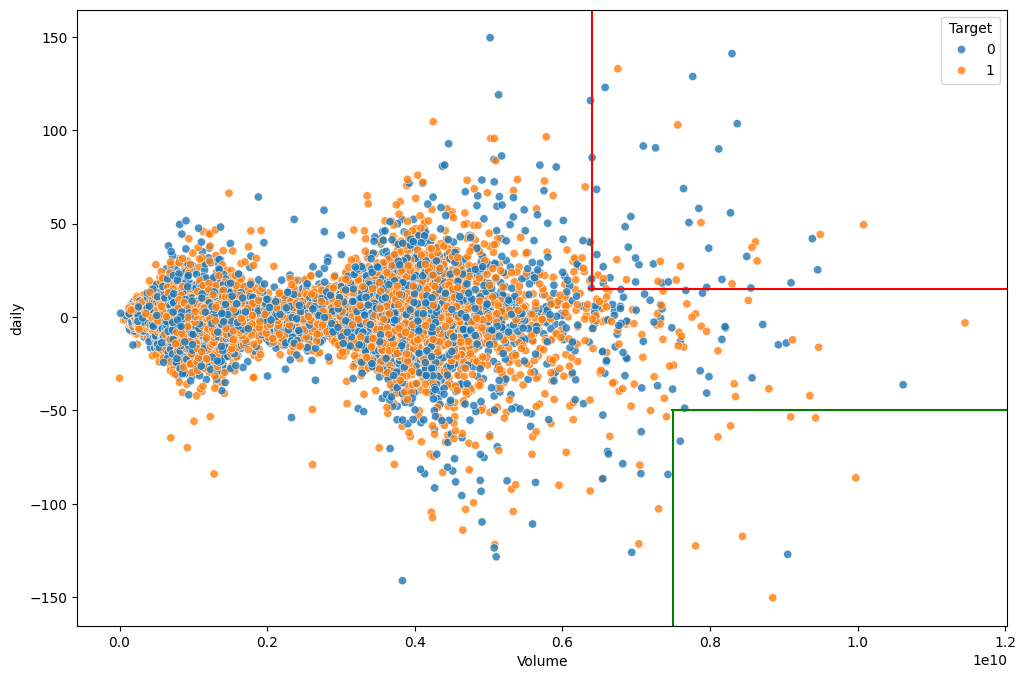

In [36]:
plt.figure(figsize = (12,8))

sns.scatterplot(y = df['daily'], x = df['Volume'], hue = df['Target'], alpha = .8)

plt.axhline(y = -50, color = 'g', xmin = 0.64)
plt.axvline(x = 7500000000, color = 'g', ymax = 0.35)

plt.axhline(y = 15, color='r', xmin = 0.55)
plt.axvline(x = 6400000000, color='r', ymin = 0.545)



#Conclusion: 
#If volume was high and price went up there is higher propability that the price will go down next day
#If the price went down a lot with high volume - price is supposed to go up the next day
#In feature enginering part this has to be added eg. column indicating market state for current day eg. large variability + price growth target = 0 


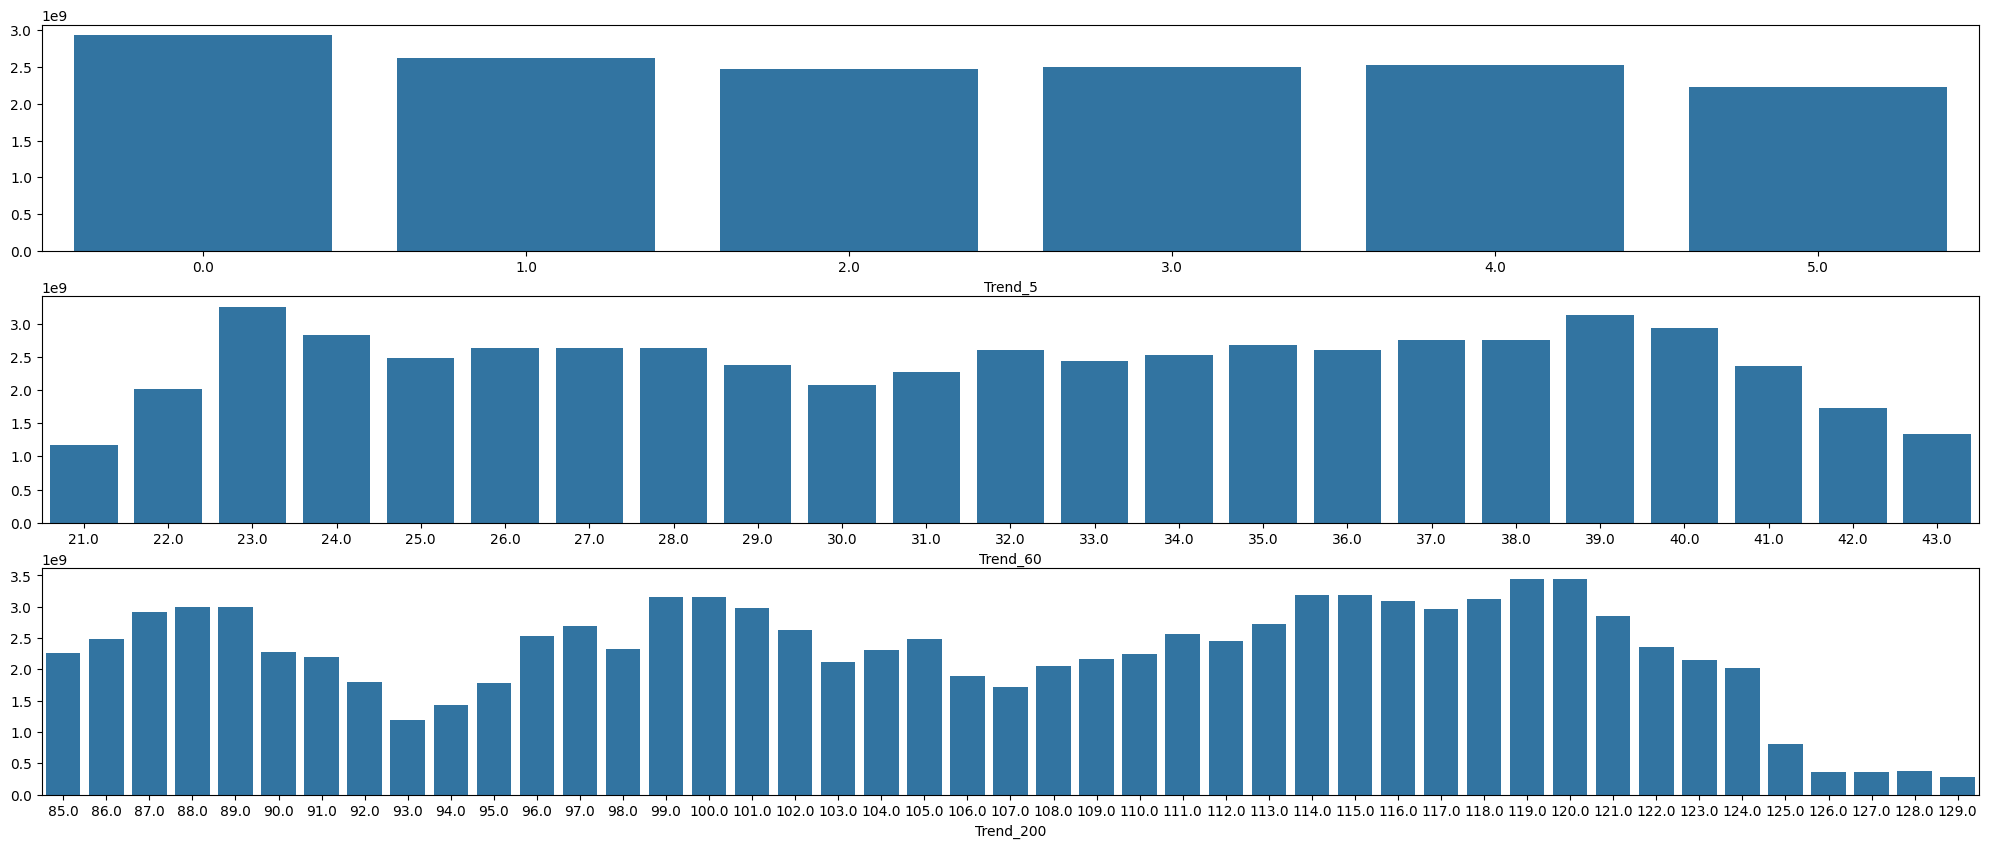

In [37]:
gv1 = df.groupby('Trend_5').mean()['Volume']
gv2 = df.groupby('Trend_60').mean()['Volume'].sort_values(ascending = False)
gv3 = df.groupby('Trend_200').mean()['Volume'].sort_values(ascending = False)
gv = [gv1, gv2, gv3]

fig, ax = plt.subplots(3, 1, figsize = (25,10))

for i, col in enumerate(gv):
    sns.barplot(x = col.index, y = col.values, ax = ax[i])

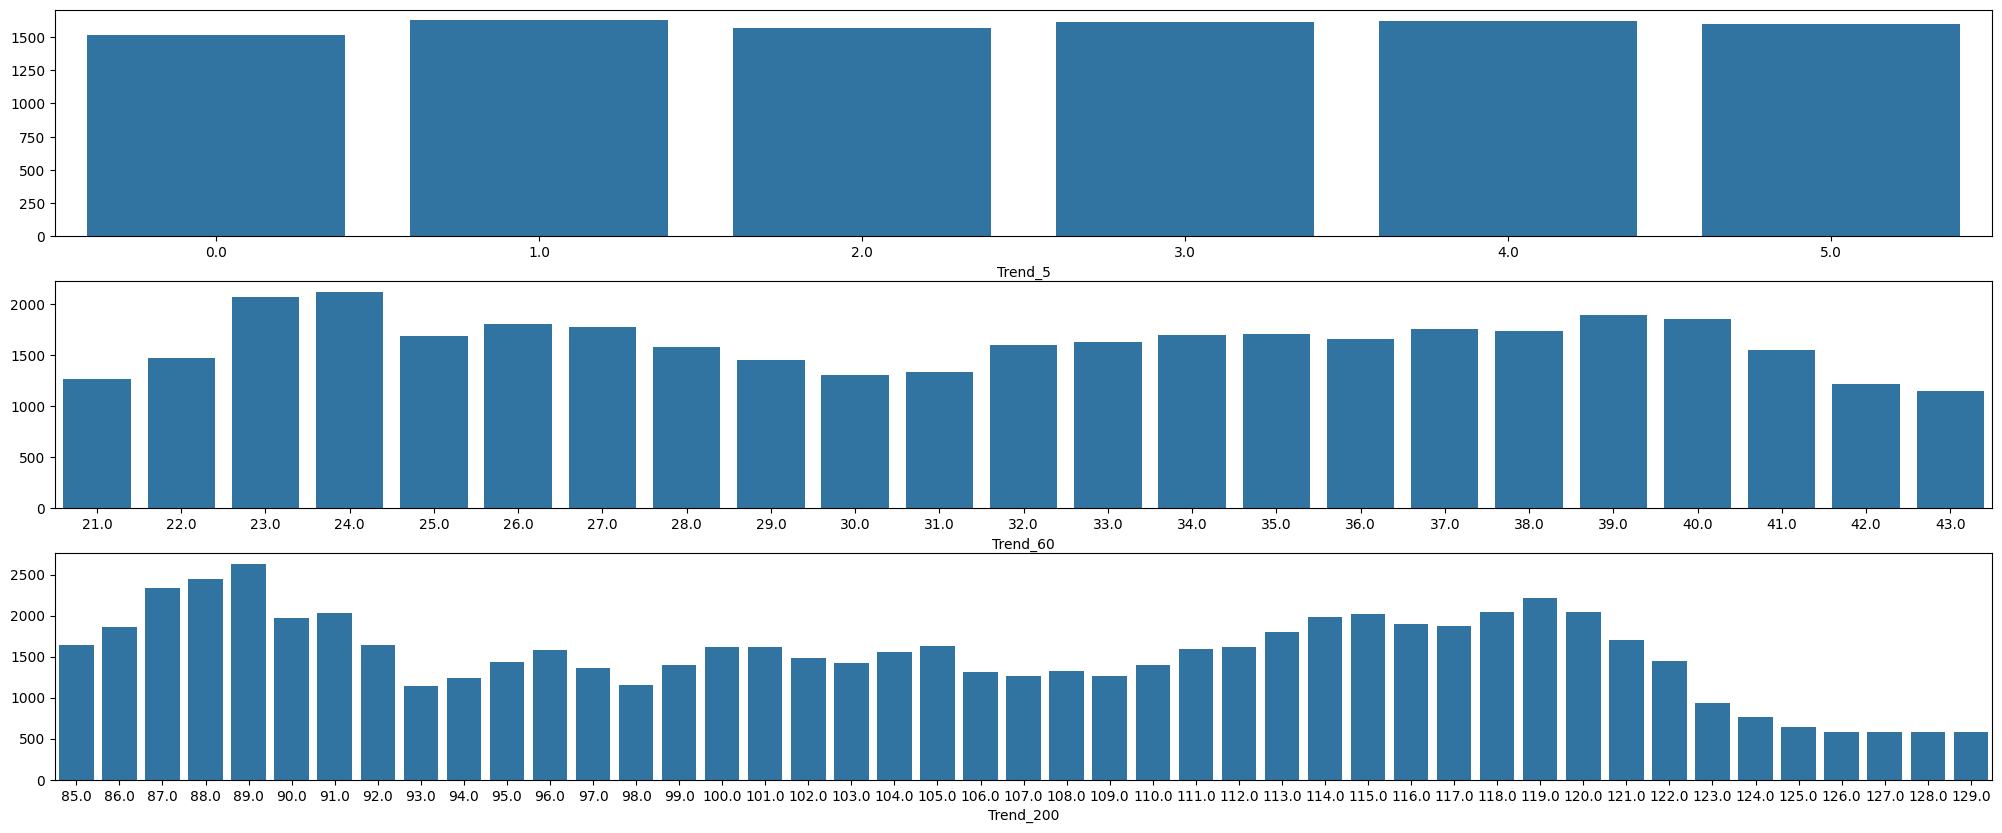

In [38]:
gp1 = df.groupby('Trend_5').mean()['Close']
gp2 = df.groupby('Trend_60').mean()['Close'].sort_values(ascending = False)
gp3 = df.groupby('Trend_200').mean()['Close'].sort_values(ascending = False)
gp = [gp1, gp2, gp3]

fig, ax = plt.subplots(3, 1, figsize = (25,10))

for i, col in enumerate(gp):
    sns.barplot(x = col.index, y = col.values, ax = ax[i])

<Axes: xlabel='Trend_200'>

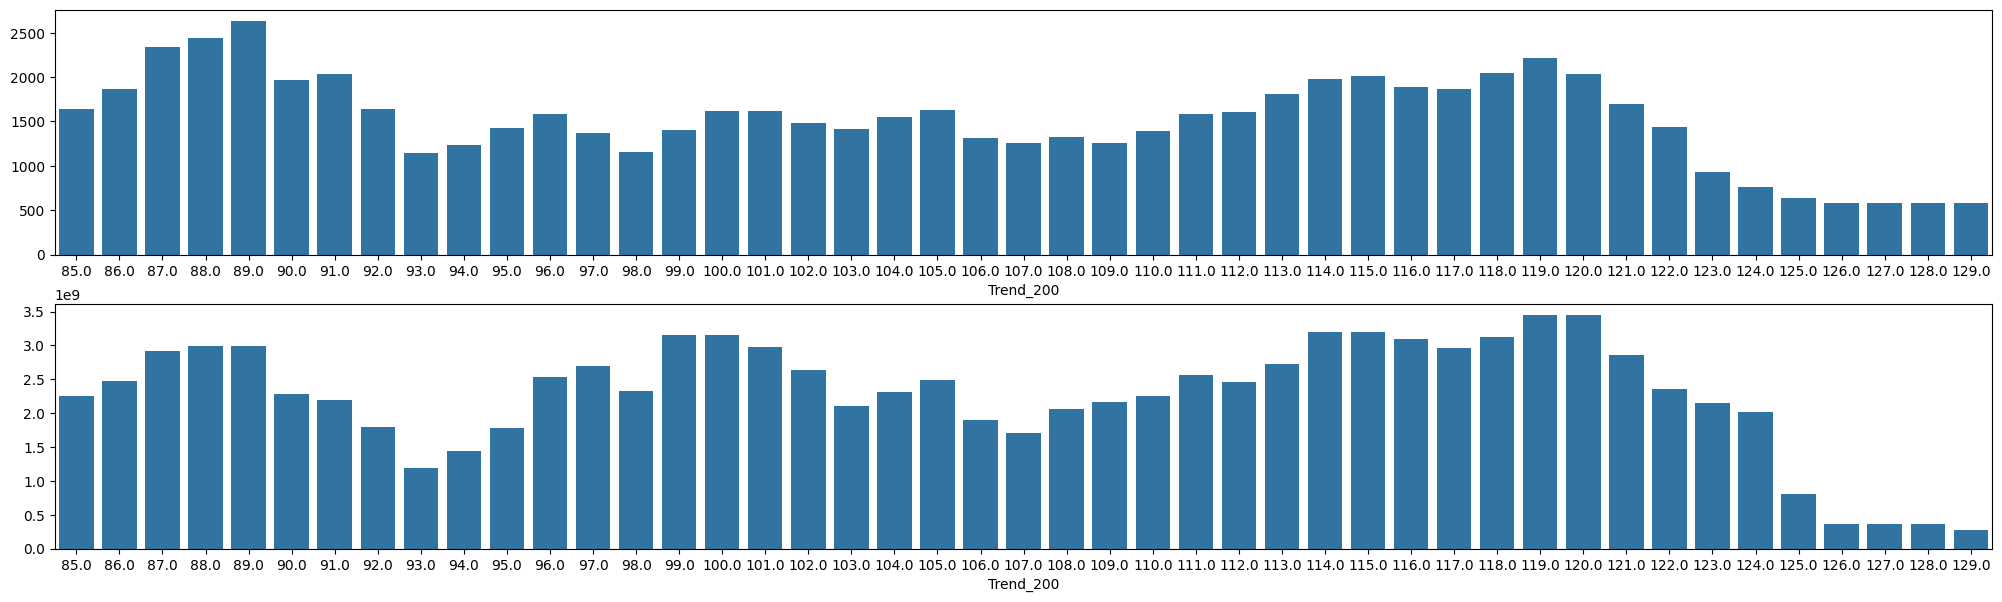

In [39]:
fig, ax = plt.subplots(2, 1, figsize = (25, 7))

sns.barplot(x = gp3.index, y = gp3.values, ax = ax[0])
sns.barplot(x = gv3.index, y = gv3.values, ax = ax[1])

In [40]:
#Conclusion - correlation between price and volume comes from old data prev 2018 - volume and price was significantly lower back then

In [41]:
df

,Open,High,Low,Close,Volume,Target,close_ratio2,Trend_2,EMA_2,close_ratio5,Trend_5,EMA_5,close_ratio60,Trend_60,EMA_60,close_ratio200,Trend_200,EMA_200,daily
Date,,,,,,,,,,,,,,,,,,,
1990-10-16,303.23,304.34,298.12,298.92,149570000,0,0.992842,1.0,0.996656,0.997710,2.0,0.992306,0.923724,29.0,0.930573,0.882752,105.0,0.884852,-4.31
1990-10-17,298.92,301.50,297.79,298.76,161260000,1,0.999732,0.0,0.998704,0.998262,2.0,0.994501,0.925950,28.0,0.932212,0.883061,105.0,0.885397,-0.16
1990-10-18,298.75,305.74,298.75,305.74,204110000,1,1.011547,1.0,1.007239,1.014615,3.0,1.011755,0.950103,28.0,0.955433,0.904360,106.0,0.906931,6.99
1990-10-19,305.74,312.48,305.74,312.48,221480000,1,1.010902,2.0,1.009626,1.028483,3.0,1.022451,0.973237,29.0,0.977249,0.924840,107.0,0.927598,6.74
1990-10-22,312.48,315.83,310.47,314.76,152650000,0,1.003635,2.0,1.005601,1.028184,3.0,1.019744,0.982311,30.0,0.984883,0.932126,107.0,0.934977,2.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,4364.27,4372.21,4347.53,4365.98,3656340000,1,1.000876,2.0,1.002461,1.016585,5.0,1.013562,1.002063,30.0,1.008761,1.027392,104.0,1.023032,1.71
2023-11-07,4366.21,4386.26,4355.41,4378.38,3791230000,1,1.001418,2.0,1.001763,1.010784,5.0,1.010900,1.005337,30.0,1.011241,1.029875,104.0,1.025673,12.17
2023-11-08,4384.37,4391.20,4359.76,4382.78,3729510000,0,1.000502,2.0,1.000922,1.005074,5.0,1.007913,1.006560,31.0,1.011850,1.030467,105.0,1.026431,-1.59


In [42]:
gdl = df.groupby('Trend_200').mean()['daily'].sort_values(ascending=False).iloc[:10]
gds = df.groupby('Trend_200').mean()['daily'].sort_values(ascending=True).iloc[:5]

<Axes: xlabel='Trend_200'>

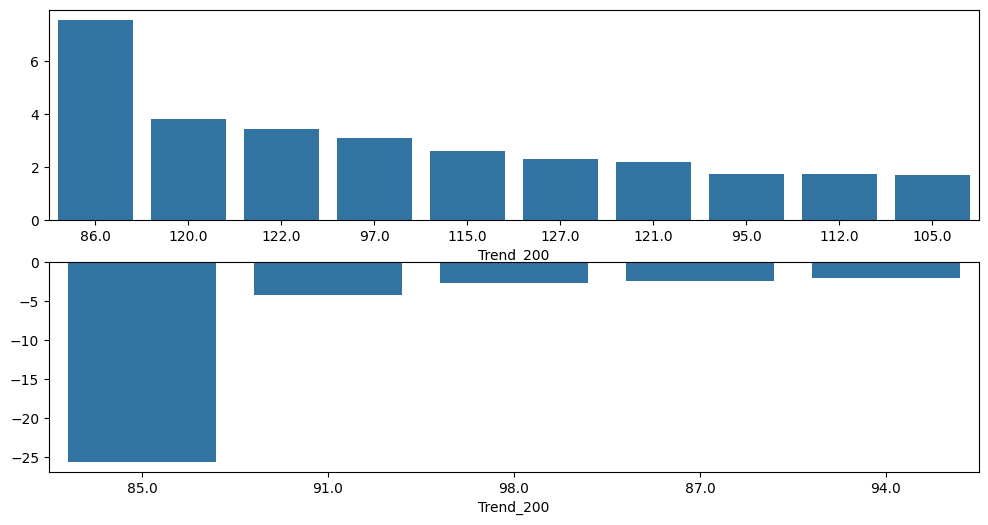

In [43]:
fig, ax = plt.subplots(2, 1, figsize = (12, 6))

sns.barplot(x = gdl.index, y = gdl.values, ax = ax[0], order = gdl.index)
sns.barplot(x = gds.index, y = gds.values, ax = ax[1], order = gds.index)

<Axes: xlabel='Date'>

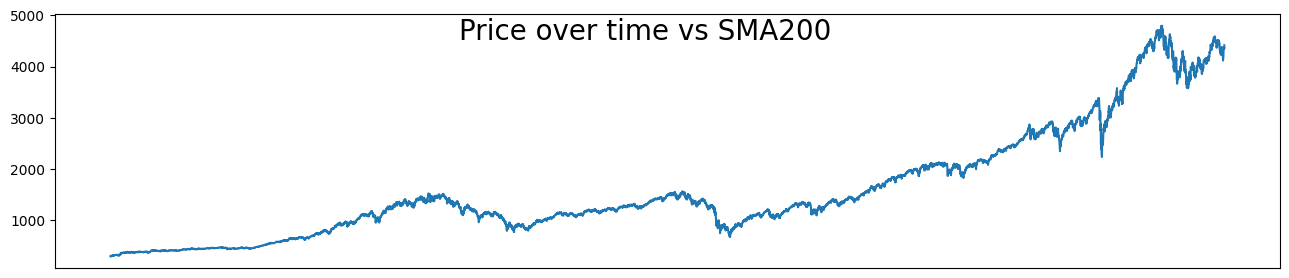

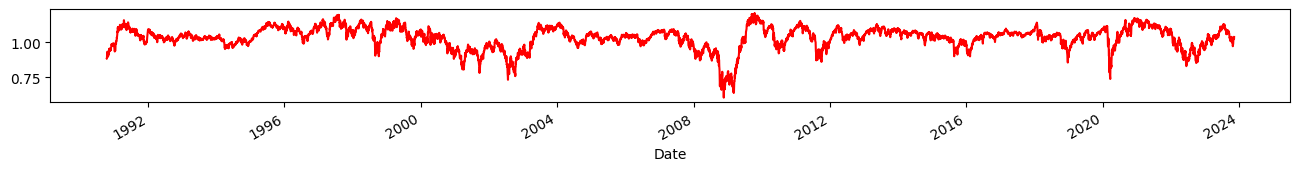

In [44]:
plt.figure(figsize = (13,6), tight_layout=True)
plt.subplots_adjust()

plt.subplot(211)
plt.suptitle('Price over time vs SMA200', y =.89, size = 20)
df['Close'].plot()
plt.xlabel('')
plt.xticks([])

plt.figure(figsize = (16,3))
plt.subplot(212)
df['close_ratio200'].plot(color='r')





Adding 13 week tresury bill as this instrument that copy change of interest rates in US 

In [45]:
ir = yf.Ticker('^IRX')

In [46]:
ir = ir.history(period = 'max')

In [47]:
ir

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1960-01-04 00:00:00-05:00,4.520,4.520,4.520,4.520,0,0.0,0.0
1960-01-05 00:00:00-05:00,4.550,4.550,4.550,4.550,0,0.0,0.0
1960-01-06 00:00:00-05:00,4.680,4.680,4.680,4.680,0,0.0,0.0
1960-01-07 00:00:00-05:00,4.630,4.630,4.630,4.630,0,0.0,0.0
1960-01-08 00:00:00-05:00,4.590,4.590,4.590,4.590,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-06 00:00:00-05:00,5.258,5.265,5.258,5.260,0,0.0,0.0
2023-11-07 00:00:00-05:00,5.275,5.278,5.273,5.273,0,0.0,0.0
2023-11-08 00:00:00-05:00,5.275,5.278,5.268,5.268,0,0.0,0.0


In [48]:
ir.index = ir.index.strftime('%Y-%m-%d')

In [49]:
ir.index = pd.to_datetime(ir.index)

In [50]:
ir = ir.loc['1990-01-01':].copy()

In [51]:
ir = ir.drop(columns= ['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])

In [52]:
df = pd.merge(df, ir, left_index = True, right_index = True)

In [53]:
df['Interest_rate'] = df['Open_y']

In [54]:
df = df.drop('Open_y', axis=1)

<Axes: xlabel='Date'>

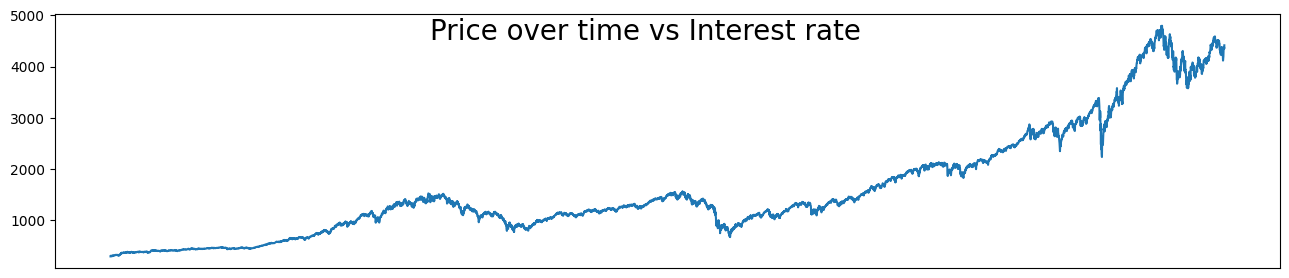

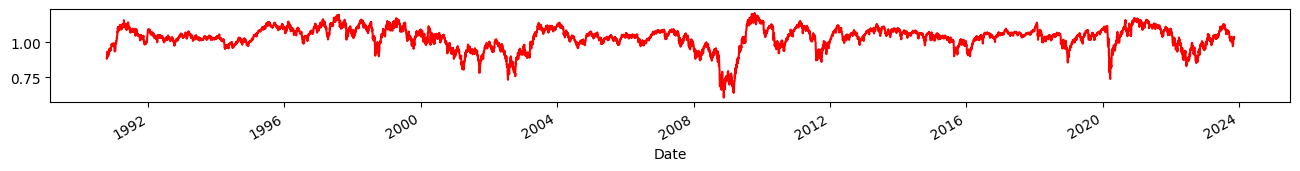

In [55]:
plt.figure(figsize = (13,6), tight_layout=True)
plt.subplots_adjust()

plt.subplot(211)
plt.suptitle('Price over time vs Interest rate', y =.89, size = 20)
df['Close'].plot()
plt.xlabel('')
plt.xticks([])

plt.figure(figsize = (16,3))
plt.subplot(212)
df['close_ratio200'].plot(color='r')


<Axes: >

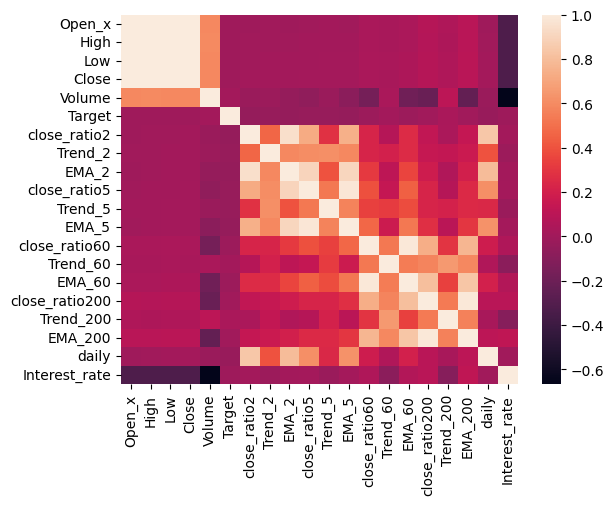

In [56]:
sns.heatmap(df.corr())

In [ ]:
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year
df['Week'] = df.index.isocalendar().week
df['Month'] = df.index.month

In [111]:
qt = df.groupby('Quarter')['Target'].mean()
yt = df.groupby('Year')['Target'].mean().sort_values(ascending = False)[:10]
wt = df.groupby('Week')['Target'].mean().sort_values(ascending = False)[:10]
mt = df.groupby('Month')['Target'].mean()

gt = [qt, yt, wt, mt]

In [121]:
wt.index.name

'Week'

Text(0.5, 0.91, 'Mean target per time period')

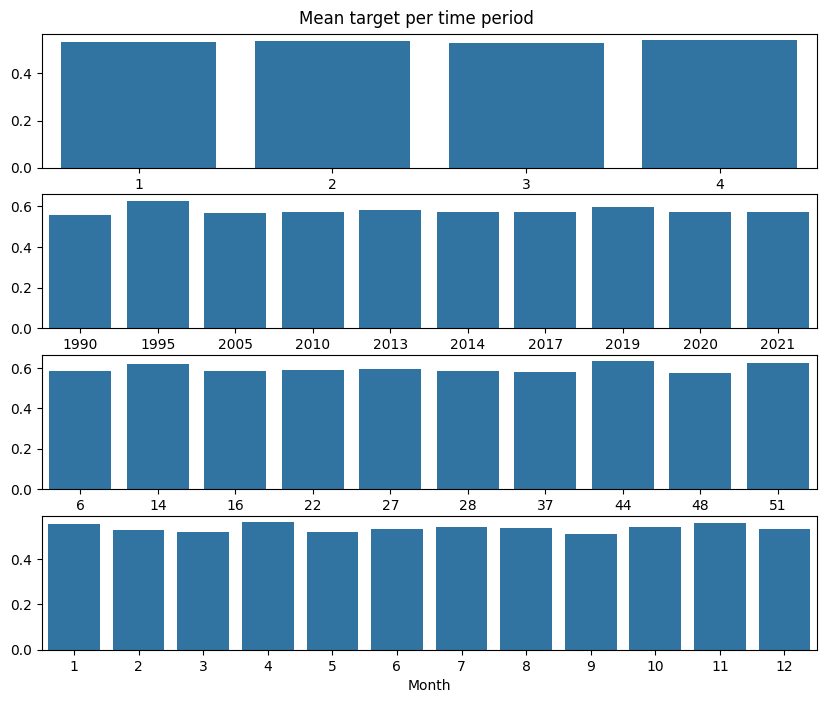

In [141]:
fig, ax = plt.subplots(4, 1, figsize = (10, 8))

for i, col in enumerate(gt):
    plt.plot(kind = bar, x = col.index, y = col.values, ax = ax[i])
    

plt.suptitle('Mean target per time period', y = 0.91)




In [143]:
yt1 = df.groupby('Year')['Target'].mean().sort_values(ascending = True)[:10]
wt1 = df.groupby('Week')['Target'].mean().sort_values(ascending = True)[:10]

gt1 = [yt1, wt1]

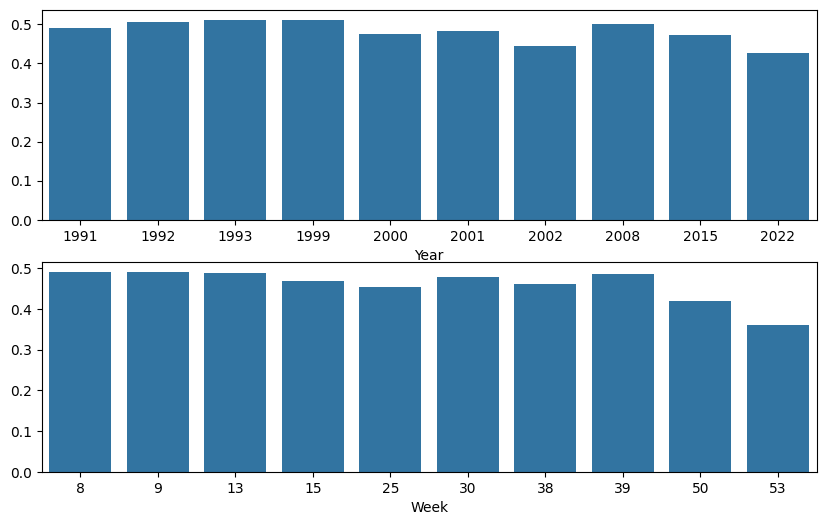

In [145]:
fig, ax = plt.subplots(2, 1, figsize = (10, 6))

for i, col in enumerate(gt1):
    sns.barplot(x = col.index, y = col.values, ax = ax[i])
    

Initial parameters tuning

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [58]:
daily = 'daily'
Interest_rate = 'Interest_rate'

In [59]:
test_predictors = new_predictors

In [60]:
test_predictors.append(daily)
test_predictors.append(Interest_rate)

In [61]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


train = df.iloc[:-150]
test = df.iloc[-150:]




In [62]:
t = [('num_col', StandardScaler(), predictors)]

processor = ColumnTransformer(t)
    

In [65]:
from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [69]:
test_predictors

['close_ratio2',
 'Trend_2',
 'EMA_2',
 'close_ratio5',
 'Trend_5',
 'EMA_5',
 'close_ratio60',
 'Trend_60',
 'EMA_60',
 'close_ratio200',
 'Trend_200',
 'EMA_200',
 'daily',
 'Interest_rate']

In [70]:
new_predictors.remove('Interest_rate')

In [71]:
predictors = new_predictors

In [72]:
t = [('num_col', StandardScaler(), predictors)]

processor = ColumnTransformer(t)

In [76]:
def objective(params):
    
    params = {'num_leaves': int(params['num_leaves']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              #'n_estimators': int(params['n_estimators']),
              'num_boost_rounds': int(params['num_boost_rounds'])
              }
    
    
    model = Pipeline([('processor', processor), 
                ('model', LGBMClassifier(**params,n_estimators = 3000, verbosity = -100))])

    model.fit(train[predictors], train['Target'])
    
    preds = model.predict(test[predictors])
    score = -(accuracy_score(test['Target'], preds)) 
    
    return {'loss':score, 'status':STATUS_OK}

In [77]:
space = {#'n_estimators': hp.quniform('n_estimators', 1000, 3000,100),
         'num_leaves': hp.quniform('num_leaves', 80, 150, 10),
         'learning_rate': hp.quniform('learning_rate', 0.01, 0.1, 0.01),
         'max_depth': hp.quniform('max_depth', 6, 12,1),
         'num_boost_rounds': hp.quniform('num_boost_rounds', 5000, 10000, 500,)
         }

In [78]:
best  = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

best

100%|███████████████| 50/50 [10:31<00:00, 12.63s/trial, best loss: -0.6466666666666666]


{'learning_rate': 0.06,
 'max_depth': 10.0,
 'num_boost_rounds': 7500.0,
 'num_leaves': 120.0}

In [82]:
#Based on initial tune LGBM is the best for the following data with accuracy = .6466
params = {'learning_rate': 0.06,
 'max_depth': 10,
 'num_boost_rounds': 7500,
 'num_leaves': 120}

In [83]:
best_model = Pipeline([('processor', processor), 
                ('model', LGBMClassifier(**params,n_estimators=3000, verbosity = -100))])

In [85]:
best_model.fit(train[predictors], train['Target'])

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('num_col', StandardScaler(),
                                                  ['close_ratio2', 'Trend_2',
                                                   'EMA_2', 'close_ratio5',
                                                   'Trend_5', 'EMA_5',
                                                   'close_ratio60', 'Trend_60',
                                                   'EMA_60', 'close_ratio200',
                                                   'Trend_200', 'EMA_200',
                                                   'daily'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.06, max_depth=10,
                                n_estimators=3000, num_boost_rounds=7500,
                                num_leaves=120, verbosity=-100))])

In [86]:
predictions_best = backtest(df, best_model, predictors)

In [87]:
precision_score(predictions_best['Target'], predictions_best['Predictions'])

0.5516252390057361

In [ ]:
#Precision on back test = 55.1% - that beats the market by 2%